## Importing Libraries

In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

In [3]:
DATASETS_FOLDER = "C:/Users/Killian/Desktop/FYP-Multistage-Throughput-Predictor/Datasets/Final_Outputs/"
IMAGES_OUTPUT_FOLDER = "C:/Users/Killian/Desktop/FYP-Multistage-Throughput-Predictor/Datasets/Images/"

## Defining Analysis Functions

In [4]:
def import_data(model_name="univariate_baseline"):
    true = np.squeeze(np.load(DATASETS_FOLDER+model_name+"_true_y.npy"))
    predicted = np.load(DATASETS_FOLDER+model_name+"_predicted_y.npy")
    return true, predicted

In [5]:
def compute_residuals(true, pred):
    residuals = np.sum(true-pred, axis=1)
    residuals = ((residuals)/true.shape[1])/ 1000
    return residuals

In [6]:
def generate_boxplot(datasets=[],title="DEFAULT", ylab="Residuals (Mbps)",xlab=[], colours=[],
                      output_folder=IMAGES_OUTPUT_FOLDER, ylim=()):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_ylabel(ylab)
    box = ax.boxplot(datasets, whis=(5,95), patch_artist=True, notch=True, flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'fuchsia'})
    ax.set_xticklabels(xlab)
    if colours:
        for bplot, colour in zip(box["boxes"], colours):
            bplot.set_color(colour)
    if ylim:
        ax.set_ylim(ylim)
    ax.yaxis.grid(True)
    plt.xticks(rotation=-45)
    plt.savefig(output_folder+title+".png", dpi=320)

In [7]:
def get_variance(data):
    return np.var(data)

In [8]:
def get_std(data):
    return np.std(data)

In [9]:
def get_ts_residuals(true, pred):
        residuals = true-pred
        residuals = residuals / 1000
        return residuals

In [10]:
import seaborn as sns
def time_step_boxplots(residuals=[], model_names=[], title="", xlim=(), savefig_path=""):
    df = pd.DataFrame()
    for model, residuals in zip(model_names, residuals):
        for i in range(residuals.shape[1]):
            temp_df = pd.DataFrame()
            temp_df["Residuals (Mb)"] = residuals[:,i]
            temp_df["Time Step"] = i+1
            temp_df["Model"] = model
            df = pd.concat([df, temp_df])
    sns.set_theme(style="whitegrid")
    box = sns.boxplot(x="Residuals (Mb)", y="Time Step",
                hue="Model",
                data=df, orient="h", whis=(5,95), saturation=1, flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'pink'})
    if xlim:
        box.set_xlim(xlim)
    box.set_title(title)
    box.set_ylabel("Horizon (seconds)")
    if savefig_path:
        plt.savefig(savefig_path, dpi=300, bbox_inches='tight')
    
    plt.show() # Display the plot on the screen
    

In [11]:
def get_mape(true, predicted, epsilon=50):
    denominator = np.squeeze(true) + epsilon
    try:
        mape = np.mean(np.abs((np.squeeze(true) - predicted)/denominator))*100
    except Exception as e:
        print(e)
        mape = "n/a"
    return mape

In [12]:
def get_mse(true, predicted):
    mse = np.mean(np.power(np.squeeze(true)-predicted, 2))
    return mse

In [13]:
def get_mae(true, predicted):
    mae = np.mean(np.abs(np.squeeze(true)-predicted))
    return mae

In [33]:
def carry_out_analysis(prefix="univariate", title_prefix="Univariate"):
    for dataset in ["low", "medium", "high", 1]:
        if dataset == 1:
            base_true, base_pred = import_data(model_name="{}_baseline".format(prefix))
            multiOne_true, multiOne_pred = import_data(model_name="{}_multiOne".format(prefix))
            multiAll_true, multiAll_pred = import_data(model_name="{}_multiAll".format(prefix))

            # Get Residuals
            base_resids = get_ts_residuals(base_true, base_pred)
            multiOne_resids = get_ts_residuals(multiOne_true, multiOne_pred)
            multiAll_resids = get_ts_residuals(multiAll_true, multiAll_pred)
            
            # Boxplot of residuals
            time_step_boxplots(residuals=[base_resids, multiOne_resids, multiAll_resids],
                                model_names=["Baseline", "Multistage One", "Multistage All"],
                                  title="Model Performance on All Test Sequences",
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"{} On All Test Data".format(title_prefix))

            # Standard Dev
            base_std = get_std(base_resids)
            multiOne_std = get_std(multiOne_resids)
            multiAll_std = get_std(multiAll_resids)

            # MAPE
            base_mape = get_mape(base_true, base_pred)
            multiOne_mape = get_mape(multiOne_true, multiOne_pred)
            multiAll_mape = get_mape(multiAll_true, multiAll_pred)

            # MSE
            base_mse = get_mse(base_true, base_pred)
            multiOne_mse = get_mse(multiOne_true, multiOne_pred)
            multiAll_mse = get_mse(multiAll_true, multiAll_pred)

            # MAE
            base_mae = get_mae(base_true, base_pred)
            multiOne_mae = get_mae(multiOne_true, multiOne_pred)
            multiAll_mae = get_mae(multiAll_true, multiAll_pred)

            # Table of metrics
            table = PrettyTable(["Model", "Mean Resids (Mb)", " Resids std (Mb)", "MAPE", "MSE", "MAE"])
            table.add_row(["Baseline",np.mean(base_resids), base_std, base_mape, base_mse, base_mae])
            table.add_row(["Multistage One",np.mean(multiOne_resids), multiOne_std, multiOne_mape, multiOne_mse, multiOne_mae])
            table.add_row(["Multistage All",np.mean(multiAll_resids), multiAll_std, multiAll_mape, multiAll_mse, multiAll_mae])
            print("Residuals of All Sequences Test Set")
            print(table)
            
        else:
            base_true, base_pred = import_data(model_name="{}_baseline_{}".format(prefix, dataset))
            single_true, single_pred = import_data(model_name="{}_multiOne_{}".format(prefix, dataset))

            # Get Residuals
            base_resids = get_ts_residuals(base_true, base_pred)
            single_resids = get_ts_residuals(single_true, single_pred)
            
            # Boxplot of residuals
            time_step_boxplots(residuals=[base_resids, single_resids],
                                model_names=["Baseline", "{} Only".format(dataset)],
                                  title="Model Performance on {} Test Sequences".format(dataset),
                                  savefig_path=IMAGES_OUTPUT_FOLDER+"{} On {} Test Set".format(title_prefix, dataset))

            # Standard Dev
            base_std = get_std(base_resids)
            single_std = get_std(single_resids)

            # MAPE
            base_mape = get_mape(base_true, base_pred)
            single_mape = get_mape(single_true, single_pred)

            # MSE
            base_mse = get_mse(base_true, base_pred)
            single_mse = get_mse(single_true, single_pred)

            # MAE
            base_mae = get_mae(base_true, base_pred)
            single_mae = get_mae(single_true, single_pred)

            # Table of metrics
            table = PrettyTable(["Model", "Mean Resids (Mb)", " Resids std (Mb)", "MAPE", "MSE", "MAE"])
            table.add_row(["Baseline",np.mean(base_resids), base_std, base_mape, base_mse, base_mae])
            table.add_row(["{} Only".format(dataset),np.mean(single_resids), single_std, single_mape, single_mse, single_mae])
            print("Residuals of {} Sequences Test Set".format(dataset))
            print(table)
    true, pred = import_data(model_name="{}_multiOne_classifier".format(prefix))
    true = np.argmax(true, axis=-1)
    pred = np.argmax(pred, axis=-1)
    conf_matrix = confusion_matrix(true, pred)
    # create a dictionary to map class names
    class_names = {0: "low", 1: "medium", 2: "high"}

    # map the class names
    true_names = [class_names[x] for x in true]
    pred_names = [class_names[x] for x in pred]
    report = classification_report(true_names, pred_names, labels=["low", "medium", "high"])
    print("Classification Report:\n",report)
    display_conf = ConfusionMatrixDisplay(conf_matrix, display_labels=["Low", "Medium", "High"])
    display_conf.plot(cmap="Oranges")
    plt.show()

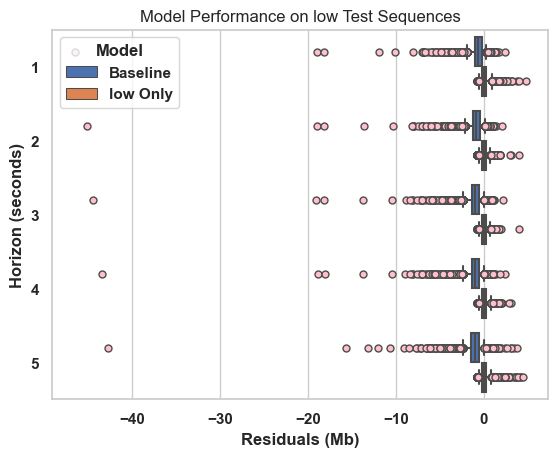

Residuals of low Sequences Test Set
+----------+----------------------+--------------------+--------------------+--------------------+--------------------+
|  Model   |   Mean Resids (Mb)   |   Resids std (Mb)  |        MAPE        |        MSE         |        MAE         |
+----------+----------------------+--------------------+--------------------+--------------------+--------------------+
| Baseline | -0.9944124481837836  | 1.1531873619154447 |  842.982018586977  | 2318697.208784369  | 1040.9150248754179 |
| low Only | 0.035435948808824135 | 0.4297831529444472 | 168.66810887278552 | 185969.26502285164 |  302.000560956852  |
+----------+----------------------+--------------------+--------------------+--------------------+--------------------+


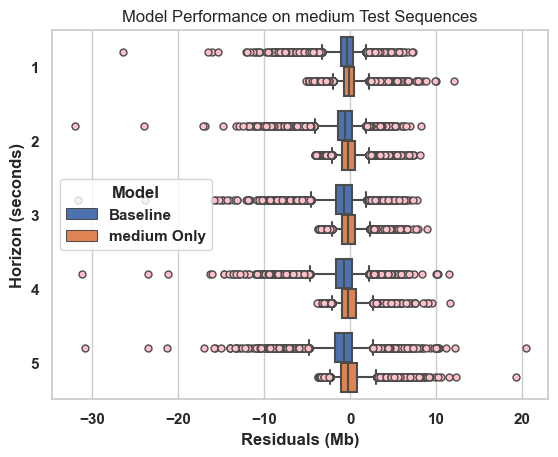

Residuals of medium Sequences Test Set
+-------------+----------------------+--------------------+--------------------+--------------------+--------------------+
|    Model    |   Mean Resids (Mb)   |   Resids std (Mb)  |        MAPE        |        MSE         |        MAE         |
+-------------+----------------------+--------------------+--------------------+--------------------+--------------------+
|   Baseline  |  -0.792320778924055  | 2.078322399999697  | 207.96478601312208 | 4947196.215055321  | 1491.2265617981845 |
| medium Only | -0.09475253497073831 | 1.4444265803599217 | 135.92456860802605 | 2095346.1889336382 | 1066.325203100205  |
+-------------+----------------------+--------------------+--------------------+--------------------+--------------------+


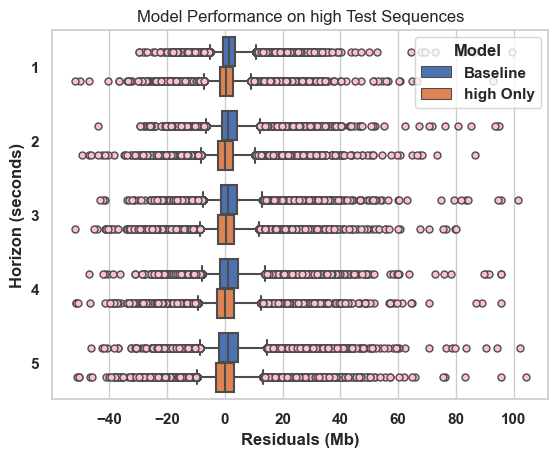

Residuals of high Sequences Test Set
+-----------+--------------------+-------------------+--------------------+-------------------+------------------+
|   Model   |  Mean Resids (Mb)  |   Resids std (Mb) |        MAPE        |        MSE        |       MAE        |
+-----------+--------------------+-------------------+--------------------+-------------------+------------------+
|  Baseline |   1.826732226216   | 6.929020658356258 | 87.36568672506802  | 51348277.91022386 | 4531.75282027518 |
| high Only | 0.6098689127601288 | 6.946280674141121 | 106.78202056650139 | 48622755.29469766 | 4397.59499981045 |
+-----------+--------------------+-------------------+--------------------+-------------------+------------------+


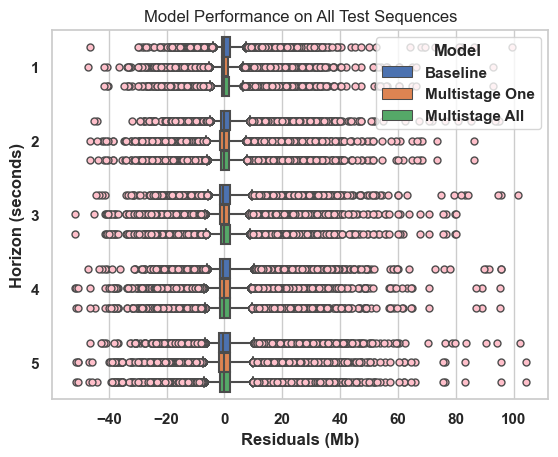

Residuals of All Sequences Test Set
+----------------+---------------------+--------------------+--------------------+--------------------+--------------------+
|     Model      |   Mean Resids (Mb)  |   Resids std (Mb)  |        MAPE        |        MSE         |        MAE         |
+----------------+---------------------+--------------------+--------------------+--------------------+--------------------+
|    Baseline    |  0.5922005103915118 | 5.411183974936267  | 246.23743253381224 | 29631613.455115028 | 3063.3823968571423 |
| Multistage One | 0.31532087532879216 | 5.3839931078269485 | 176.30902482250207 | 29086809.039546195 | 3012.054067480143  |
| Multistage All |  0.4269414967051473 | 5.346072034664115  | 183.3883688907696  | 28762765.241426535 | 2964.5964949130052 |
+----------------+---------------------+--------------------+--------------------+--------------------+--------------------+
Classification Report:
               precision    recall  f1-score   support

         l

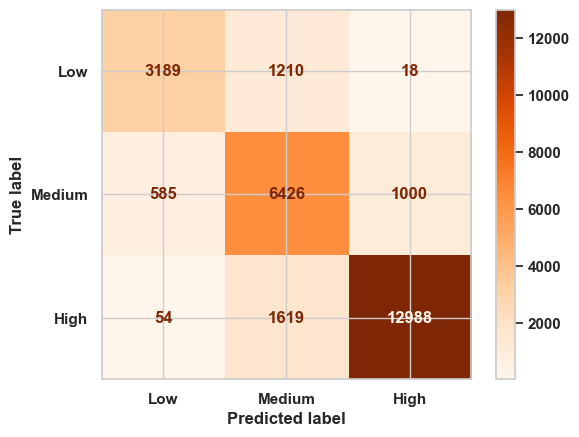

In [34]:
carry_out_analysis("presentation", "All Network")

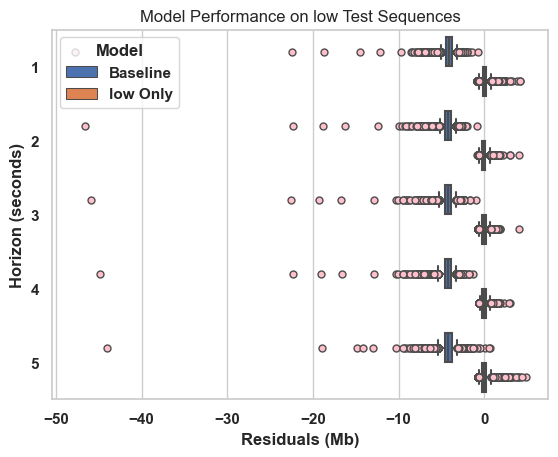

Residuals of low Sequences Test Set
+----------+-----------------------+---------------------+--------------------+--------------------+-------------------+
|  Model   |    Mean Resids (Mb)   |    Resids std (Mb)  |        MAPE        |        MSE         |        MAE        |
+----------+-----------------------+---------------------+--------------------+--------------------+-------------------+
| Baseline |   -4.252538167018816  |  1.0142689950947925 | 3250.7041668760485 | 19112822.456362344 | 4252.652979853169 |
| low Only | 6.179945827312149e-05 | 0.41199235665572387 | 164.95342862326072 | 169737.70576191024 | 285.8580453767101 |
+----------+-----------------------+---------------------+--------------------+--------------------+-------------------+


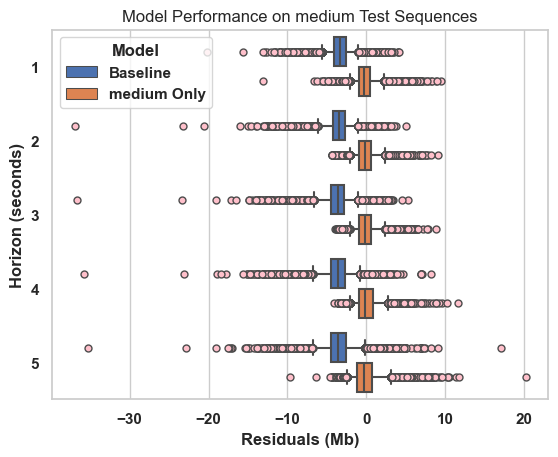

Residuals of medium Sequences Test Set
+-------------+-----------------------+--------------------+--------------------+--------------------+--------------------+
|    Model    |    Mean Resids (Mb)   |   Resids std (Mb)  |        MAPE        |        MSE         |        MAE         |
+-------------+-----------------------+--------------------+--------------------+--------------------+--------------------+
|   Baseline  |  -3.5652476398632675  | 1.8595463865314277 | 424.06526649859114 | 16168903.49721269  |  3626.32346207314  |
| medium Only | -0.059591838974032176 | 1.4733456983185265 | 133.10715130255687 | 2174298.7340260134 | 1085.7733698774732 |
+-------------+-----------------------+--------------------+--------------------+--------------------+--------------------+


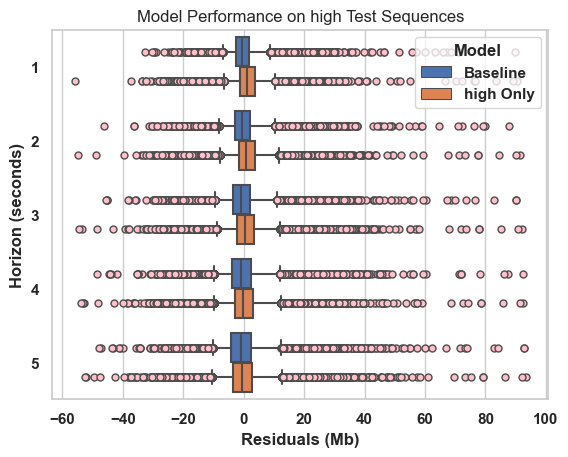

Residuals of high Sequences Test Set
+-----------+----------------------+-------------------+--------------------+--------------------+-------------------+
|   Model   |   Mean Resids (Mb)   |   Resids std (Mb) |        MAPE        |        MSE         |        MAE        |
+-----------+----------------------+-------------------+--------------------+--------------------+-------------------+
|  Baseline | -0.15994315607006288 |  6.83127050371585 | 103.33568269098143 | 46691838.508111864 | 4426.547220853669 |
| high Only |  0.8067181569226515  | 7.126612112623312 | 105.19998279674574 |  51439394.388498   | 4573.335291609981 |
+-----------+----------------------+-------------------+--------------------+--------------------+-------------------+


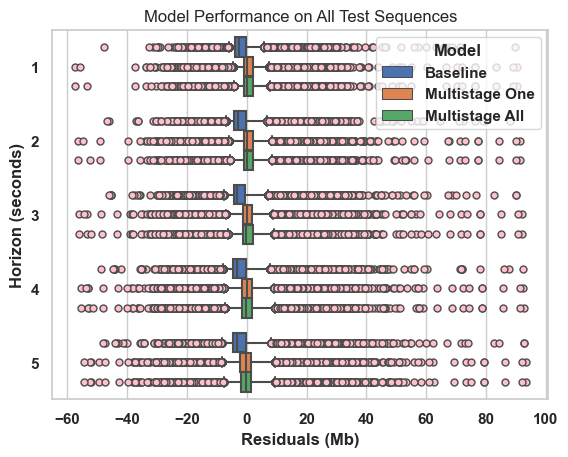

Residuals of All Sequences Test Set
+----------------+---------------------+-------------------+--------------------+--------------------+--------------------+
|     Model      |   Mean Resids (Mb)  |   Resids std (Mb) |        MAPE        |        MSE         |        MAE         |
+----------------+---------------------+-------------------+--------------------+--------------------+--------------------+
|    Baseline    | -1.8343086322671835 | 5.459279890756332 | 711.3792166373049  | 33168425.084026374 | 4161.543588662956  |
| Multistage One | 0.42632499469265817 |  5.55352007413317 | 176.44655438813308 | 31023338.214899782 | 3111.597993117481  |
| Multistage All |  0.5470724258147546 | 5.490278173972351 | 185.04929293250598 | 30442442.66668402  | 3061.7742658424604 |
+----------------+---------------------+-------------------+--------------------+--------------------+--------------------+
Classification Report:
               precision    recall  f1-score   support

         low     

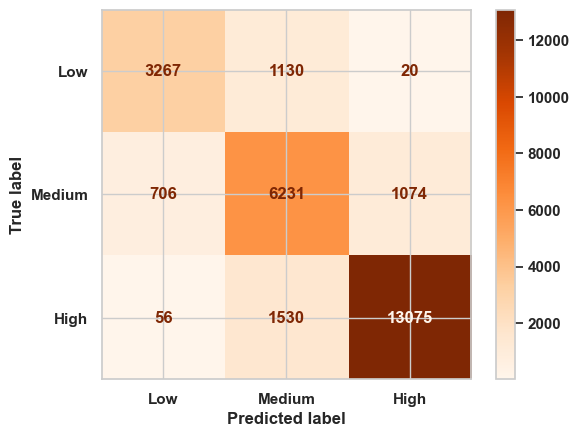

In [35]:
carry_out_analysis("pca_selected", "PCA Selected")

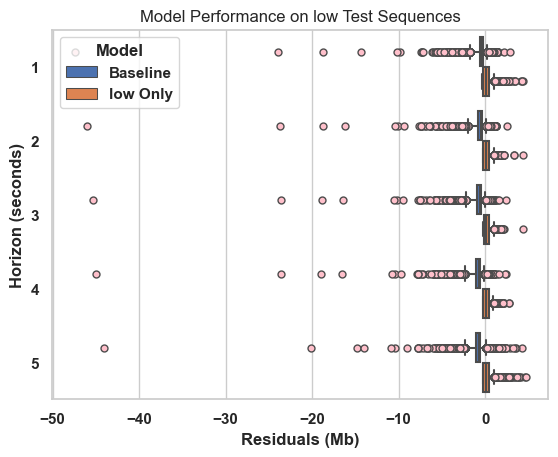

Residuals of low Sequences Test Set
+----------+---------------------+---------------------+--------------------+--------------------+--------------------+
|  Model   |   Mean Resids (Mb)  |    Resids std (Mb)  |        MAPE        |        MSE         |        MAE         |
+----------+---------------------+---------------------+--------------------+--------------------+--------------------+
| Baseline | -0.7762381709646851 |  1.1671170484301525 | 666.8054145768683  | 1964707.9027989106 | 816.7000821357403  |
| low Only |  0.1885319164900264 | 0.45674851909755215 | 173.81056182660967 | 244163.49323320927 | 357.53536477080826 |
+----------+---------------------+---------------------+--------------------+--------------------+--------------------+


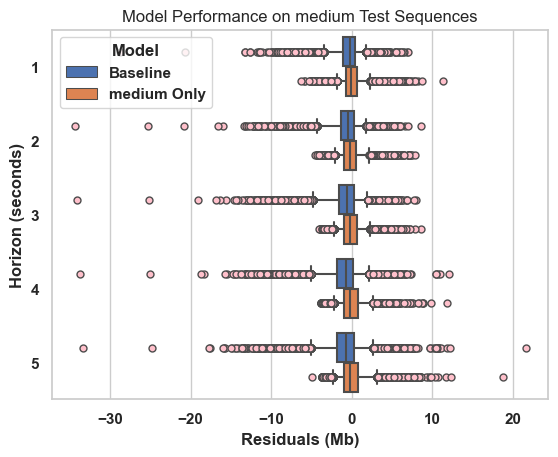

Residuals of medium Sequences Test Set
+-------------+----------------------+--------------------+--------------------+--------------------+--------------------+
|    Model    |   Mean Resids (Mb)   |   Resids std (Mb)  |        MAPE        |        MSE         |        MAE         |
+-------------+----------------------+--------------------+--------------------+--------------------+--------------------+
|   Baseline  | -0.8049365134009381  |  2.19292984689831  | 209.0380612513984  | 5456864.104023501  | 1508.3330901944075 |
| medium Only | -0.03867328308861281 | 1.4463362629076884 | 133.94528104146585 | 2093384.2082266302 | 1060.0644458206812 |
+-------------+----------------------+--------------------+--------------------+--------------------+--------------------+


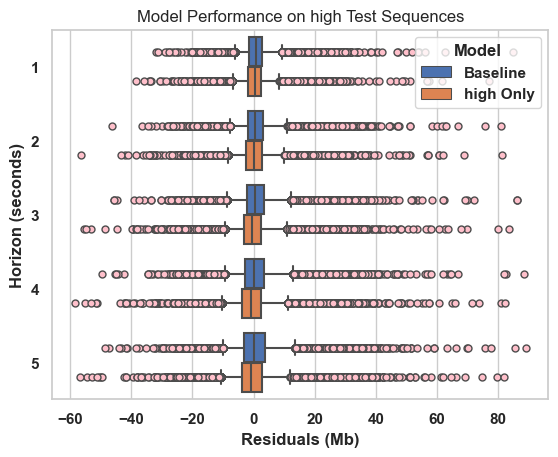

Residuals of high Sequences Test Set
+-----------+--------------------+-------------------+--------------------+-------------------+-------------------+
|   Model   |  Mean Resids (Mb)  |   Resids std (Mb) |        MAPE        |        MSE        |        MAE        |
+-----------+--------------------+-------------------+--------------------+-------------------+-------------------+
|  Baseline | 0.9350809823580845 | 6.802553219352019 | 93.43997036434435  | 47149106.74568428 | 4398.373021769148 |
| high Only | 0.0529265359731645 | 6.796297953811907 | 106.69682172848877 | 46192467.09519803 | 4351.913263423256 |
+-----------+--------------------+-------------------+--------------------+-------------------+-------------------+


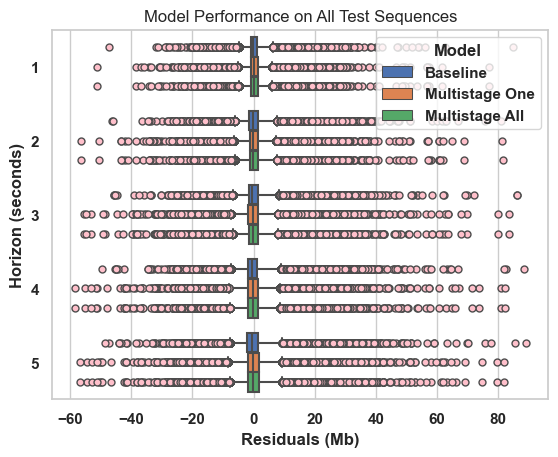

Residuals of All Sequences Test Set
+----------------+---------------------+-------------------+-------------------+--------------------+--------------------+
|     Model      |   Mean Resids (Mb)  |   Resids std (Mb) |        MAPE       |        MSE         |        MAE         |
+----------------+---------------------+-------------------+-------------------+--------------------+--------------------+
|    Baseline    | 0.14146819278705228 |  5.23755146730833 | 221.1158341158186 | 27451958.62227407  | 2959.6946184220874 |
| Multistage One | 0.12972972254874263 | 5.335037500350771 | 184.2527179163386 | 28479454.93106158  | 3002.7468395856135 |
| Multistage All |  0.2350396610517382 | 5.269586055783587 | 190.3469743796921 | 27823780.841576137 | 2922.2820822127346 |
+----------------+---------------------+-------------------+-------------------+--------------------+--------------------+


In [17]:
carry_out_analysis("univariate", "Univariate")

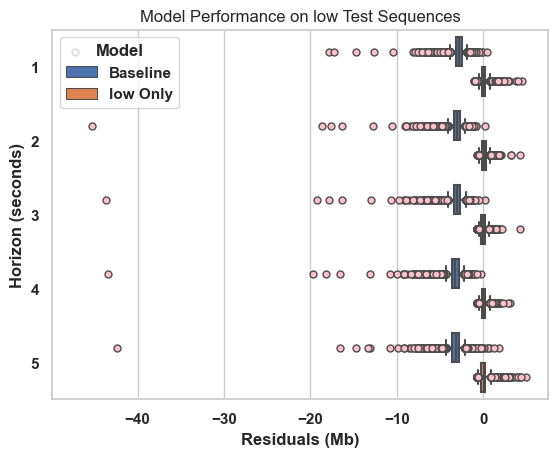

Residuals of low Sequences Test Set
+----------+---------------------+---------------------+--------------------+--------------------+--------------------+
|  Model   |   Mean Resids (Mb)  |    Resids std (Mb)  |        MAPE        |        MSE         |        MAE         |
+----------+---------------------+---------------------+--------------------+--------------------+--------------------+
| Baseline | -3.1172767181020604 |  1.0537041945695318 |  2425.5187180392   | 10827706.666874578 | 3117.8027288238122 |
| low Only | 0.06149421770483058 | 0.41599249360153967 | 152.32319379723262 | 176831.29354395613 | 288.9365159795542  |
+----------+---------------------+---------------------+--------------------+--------------------+--------------------+


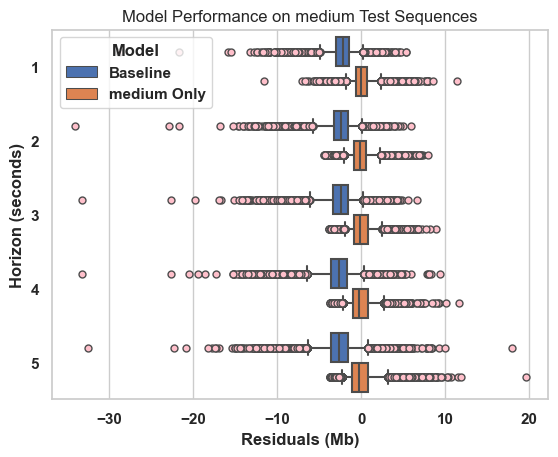

Residuals of medium Sequences Test Set
+-------------+------------------------+--------------------+--------------------+-------------------+--------------------+
|    Model    |    Mean Resids (Mb)    |   Resids std (Mb)  |        MAPE        |        MSE        |        MAE         |
+-------------+------------------------+--------------------+--------------------+-------------------+--------------------+
|   Baseline  |   -2.57862281745237    | 2.0533739473225556 | 342.73186981047775 | 10865640.20222901 | 2727.837567922257  |
| medium Only | -0.0005777127508790723 | 1.4620807414707224 | 132.06658040457668 |  2137680.4283316  | 1074.3740427811997 |
+-------------+------------------------+--------------------+--------------------+-------------------+--------------------+


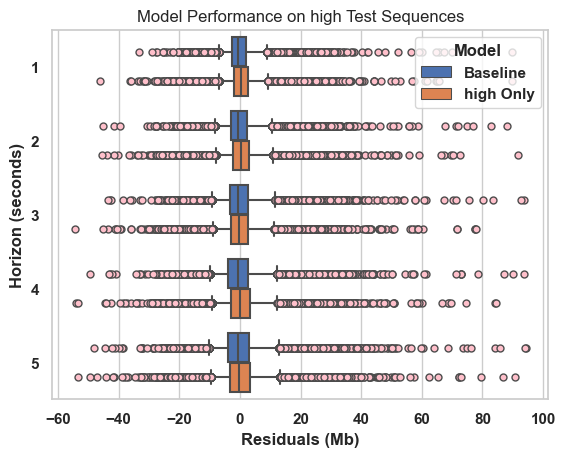

Residuals of high Sequences Test Set
+-----------+---------------------+--------------------+--------------------+-------------------+-------------------+
|   Model   |   Mean Resids (Mb)  |   Resids std (Mb)  |        MAPE        |        MSE        |        MAE        |
+-----------+---------------------+--------------------+--------------------+-------------------+-------------------+
|  Baseline | 0.05720539371328215 | 6.927918426993517  | 97.93651941561772  | 47999326.18814622 |  4495.53912210525 |
| high Only |  0.5475762936605909 | 6.9292450983718314 | 105.76974205707053 | 48314277.43068911 | 4409.781228577521 |
+-----------+---------------------+--------------------+--------------------+-------------------+-------------------+


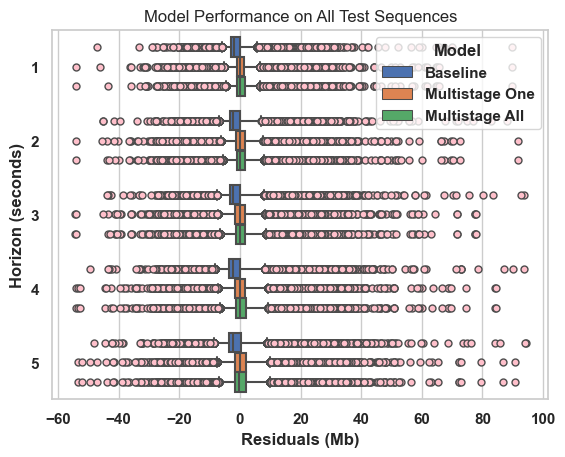

Residuals of All Sequences Test Set
+----------------+---------------------+-------------------+--------------------+--------------------+--------------------+
|     Model      |   Mean Resids (Mb)  |   Resids std (Mb) |        MAPE        |        MSE         |        MAE         |
+----------------+---------------------+-------------------+--------------------+--------------------+--------------------+
|    Baseline    | -1.2399007115665386 | 5.423969566553386 | 549.8537597655732  | 30956799.63344054  | 3748.1317316560853 |
| Multistage One | 0.38241243364834504 | 5.411809625837944 | 171.65120476463352 | 29433922.695721086 | 3028.722558255359  |
| Multistage All |  0.4836663817617593 | 5.356761570798119 | 181.16045781228013 | 28928827.695226047 | 2968.890152491508  |
+----------------+---------------------+-------------------+--------------------+--------------------+--------------------+
Classification Report:
               precision    recall  f1-score   support

         low     

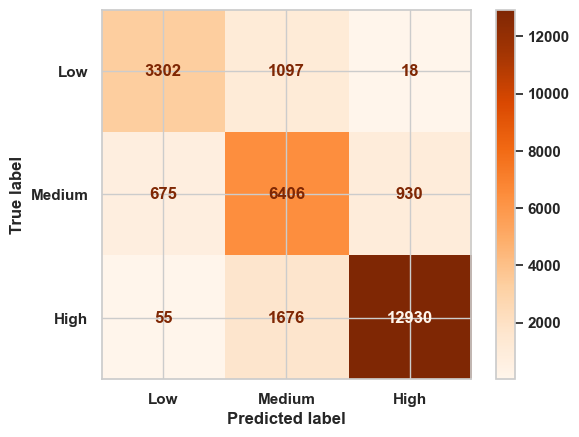

In [36]:
carry_out_analysis("with_upsampling", "Upsampling")

# Individual Models

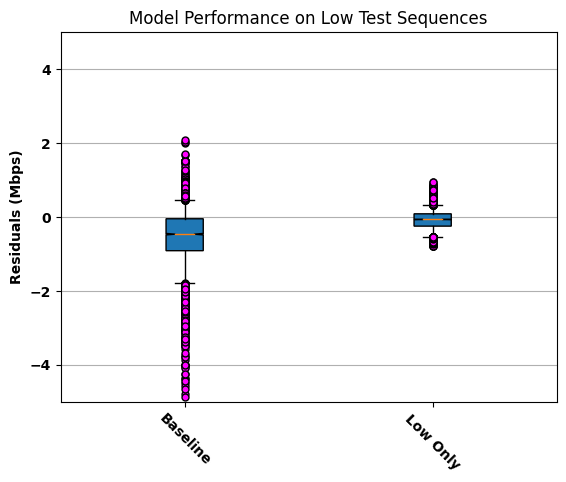

In [14]:
true, pred = import_data("solo_low_all_network")
low = compute_residuals(true, pred)
low_ts = get_ts_residuals(true, pred)
true, pred = import_data("standard_4_all_network_baseline_low")
base_low = compute_residuals(true, pred)
base_low_ts = get_ts_residuals(true, pred)
generate_boxplot(datasets=[base_low, low], xlab=["Baseline", "Low Only"], title="Model Performance on Low Test Sequences", ylim=(-5,5))

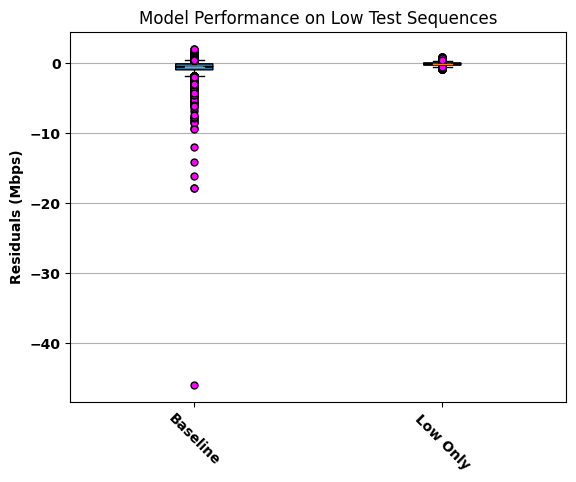

In [15]:
generate_boxplot(datasets=[base_low, low], xlab=["Baseline", "Low Only"], title="Model Performance on Low Test Sequences")

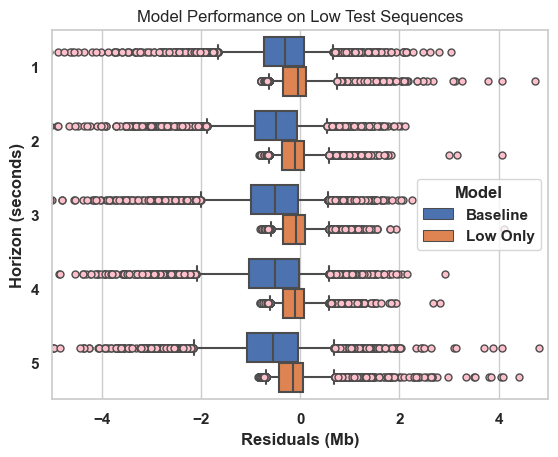

In [16]:
time_step_boxplots([base_low_ts, low_ts], model_names=["Baseline", "Low Only"], xlim=(-5,5), title="Model Performance on Low Test Sequences")

In [17]:
base_std = get_std(base_low)
low_std = get_std(low)
table_low = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)"])
table_low.add_row(["Baseline", np.mean(base_low_ts), np.std(base_low_ts)])
table_low.add_row(["Low Only Model", np.mean(low_ts), np.std(low_ts)])
print("Residuals of Low Sequences Test Set")
print(table_low)

Residuals of Low Sequences Test Set
+----------------+----------------------+--------------------+
|     Model      |      Mean (Mb)       | Standard Dev (Mb)  |
+----------------+----------------------+--------------------+
|    Baseline    | -0.5860041683526068  | 1.2697900648101184 |
| Low Only Model | -0.08374551402536326 | 0.4151138109984922 |
+----------------+----------------------+--------------------+


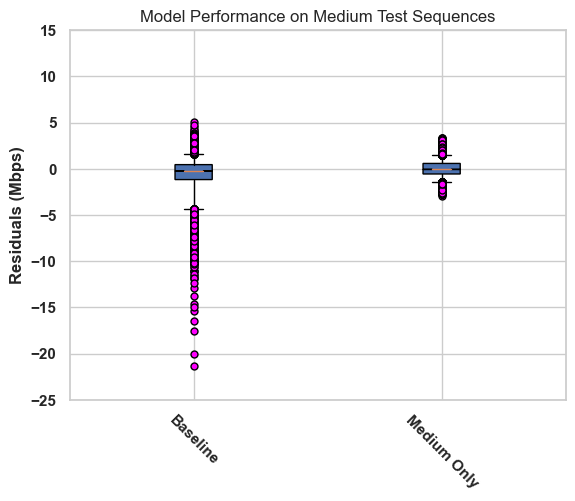

In [18]:
true, pred = import_data("solo_medium_all_network")
medium = compute_residuals(true, pred)
medium_ts = get_ts_residuals(true, pred)
true, pred = import_data("standard_4_all_network_baseline_medium")
base_medium = compute_residuals(true, pred)
base_medium_ts = get_ts_residuals(true, pred)
generate_boxplot(datasets=[base_medium, medium], xlab=["Baseline", "Medium Only"], title="Model Performance on Medium Test Sequences", ylim=(-25,15))

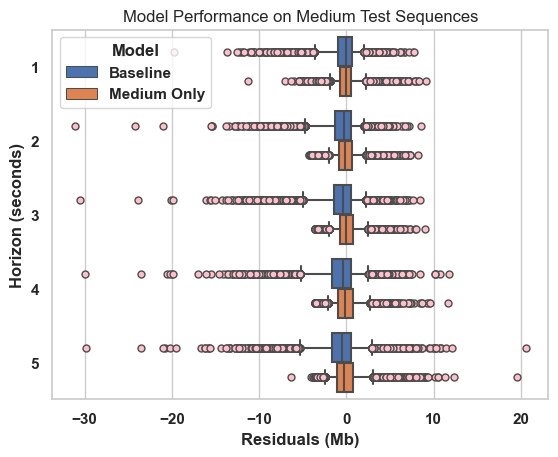

In [19]:
time_step_boxplots([base_medium_ts, medium_ts], model_names=["Baseline", "Medium Only"], title="Model Performance on Medium Test Sequences")


In [20]:
base_std = get_std(base_medium_ts)
medium_std = get_std(medium_ts)
table_medium = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)"])
table_medium.add_row(["Baseline",np.mean(base_medium_ts), base_std])
table_medium.add_row(["Medium Only Model",np.mean(medium_ts), medium_std])
print("Residuals of Medium Sequences Test Set")
print(table_medium)

Residuals of Medium Sequences Test Set
+-------------------+----------------------+--------------------+
|       Model       |      Mean (Mb)       | Standard Dev (Mb)  |
+-------------------+----------------------+--------------------+
|      Baseline     | -0.6186391210249489  | 2.3154437980716804 |
| Medium Only Model | 0.007299761038765521 | 1.4568877461239058 |
+-------------------+----------------------+--------------------+


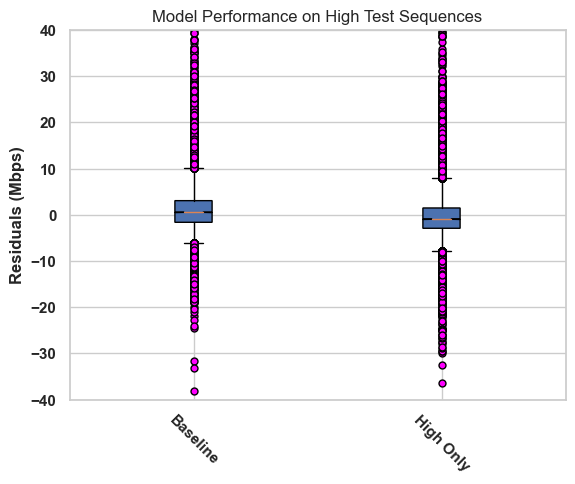

In [21]:
true, pred = import_data("solo_high_all_network")
high = compute_residuals(true, pred)
high_ts = get_ts_residuals(true, pred)
true, pred = import_data("standard_4_all_network_baseline_high")
base_high = compute_residuals(true, pred)
base_high_ts = get_ts_residuals(true, pred)
generate_boxplot(datasets=[base_high, high], xlab=["Baseline", "High Only"], title="Model Performance on High Test Sequences", ylim=(-40, 40))

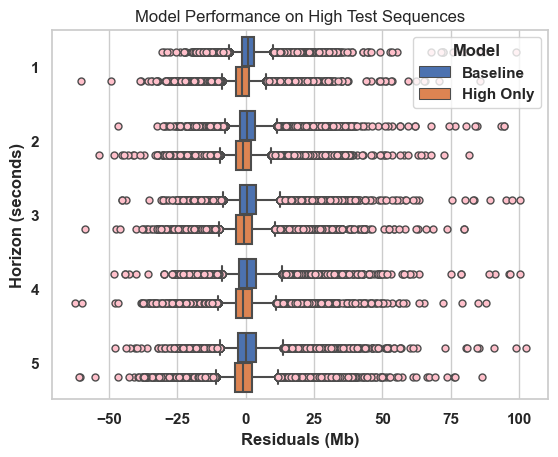

In [22]:
time_step_boxplots([base_high_ts, high_ts], model_names=["Baseline", "High Only"], title="Model Performance on High Test Sequences")


In [23]:
base_std = get_std(base_high_ts)
high_std = get_std(high_ts)
table_high = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)"])
table_high.add_row(["Baseline",np.mean(base_high_ts), base_std])
table_high.add_row(["High Only Model",np.mean(high_ts), high_std])
print("Residuals of High Sequences Test Set")
print(table_high)

Residuals of High Sequences Test Set
+-----------------+---------------------+-------------------+
|      Model      |      Mean (Mb)      | Standard Dev (Mb) |
+-----------------+---------------------+-------------------+
|     Baseline    |  1.1603552227945595 | 7.049726575529738 |
| High Only Model | -0.5036992952485793 |  6.93367129172688 |
+-----------------+---------------------+-------------------+


In [24]:
true, pred = import_data("standardized_multiOne")
multi_one_ts = get_ts_residuals(true, pred)
multi_one_mape = get_mape(true, pred)

true, pred = import_data("standardized_multiAll")
multi_all_ts = get_ts_residuals(true, pred)
multi_all_mape = get_mape(true, pred)

true, pred = import_data("standard_4_all_network_baseline")
base_ts = get_ts_residuals(true, pred)
base_mape = get_mape(true, pred)
# generate_boxplot(datasets=[base, multi_one, multi_all], xlab=["Baseline", "Multistage One", "Multistage All"], title="Model Performance on All Test Sequences")
# generate_boxplot(datasets=[base, multi_one], xlab=["Baseline", "Multistage One"], title="Model Performance on all Test Sequences")

In [25]:
base_std = get_std(base_ts)
multi_one_std = get_std(multi_one_ts)
multi_all_std = get_std(multi_all_ts)
table = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)", "MAPE"])
table.add_row(["Baseline",np.mean(base_ts), base_std, base_mape])
table.add_row(["Multistage One",np.mean(multi_one_ts), multi_one_std, multi_one_mape])
table.add_row(["Multistage All",np.mean(multi_all_ts), multi_all_std, multi_all_mape])
print("Residuals of All Sequences Test Set")
print(table)

Residuals of All Sequences Test Set
+----------------+----------------------+-------------------+--------------------+
|     Model      |      Mean (Mb)       | Standard Dev (Mb) |        MAPE        |
+----------------+----------------------+-------------------+--------------------+
|    Baseline    |  0.3495023629216359  |  5.43339845552992 | 217.23585326730733 |
| Multistage One | -0.10979356710495881 | 5.445357011456335 | 180.5777406077178  |
| Multistage All | 0.033220325374335384 | 5.343231911706903 | 188.31387775169404 |
+----------------+----------------------+-------------------+--------------------+


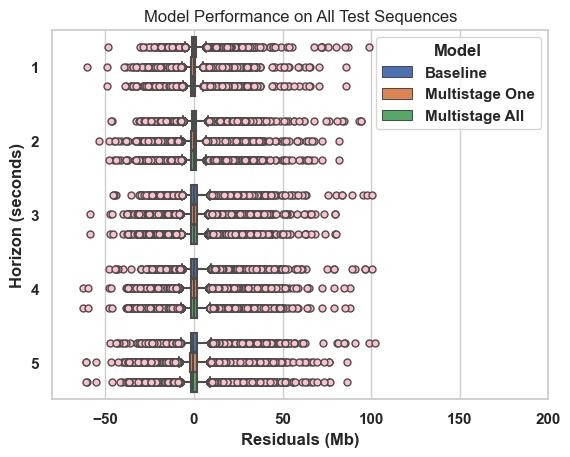

In [26]:
time_step_boxplots([base_ts, multi_one_ts, multi_all_ts], model_names=["Baseline", "Multistage One", "Multistage All"], title="Model Performance on All Test Sequences", xlim=(-80, 200))


In [27]:
true, pred = import_data("presentation_2_multiOne")
multi_one_ts = get_ts_residuals(true, pred)
multi_one_mape = get_mape(true, pred)

true, pred = import_data("presentation_2_multiAll")
multi_all_ts = get_ts_residuals(true, pred)
multi_all_mape = get_mape(true, pred)

true_low, pred_low = import_data("standard_4_all_network_baseline_low")
true_low = np.squeeze(true_low)
true_medium, pred_medium = import_data("standard_4_all_network_baseline_medium")
true_medium = np.squeeze(true_medium)
true = np.zeros((len(true_low)+len(true_medium), true_low.shape[1]))
pred = np.zeros((len(pred_low)+len(pred_medium), pred_low.shape[1]))


true[:len(true_low),:] = true_low
true[len(true_low):,:] = true_medium
pred[:len(pred_low),:] = pred_low
pred[len(pred_low):,:] = pred_medium

base_mape = get_mape(true, pred)
base_ts = get_ts_residuals(true, pred)
time_step_boxplots([base_ts, multi_one_ts, multi_all_ts], model_names=["Baseline", "Multistage One", "Multistage All"], title="Model Performance on Med&Low Test Sequences", xlim=(-50,44))


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/knola/Desktop/FYP-Multistage-Throughput-Predictor/Datasets/Final_Outputs/presentation_2_multiOne_true_y.npy'

In [60]:
base_std = get_std(base_ts)
multi_one_std = get_std(multi_one_ts)
multi_all_std = get_std(multi_all_ts)
table = PrettyTable(["Model","Mean (Mb)", "Standard Dev (Mb)", "MAPE"])
table.add_row(["Baseline",np.mean(base), base_std, base_mape])
table.add_row(["Multistage One",np.mean(multi_one), multi_one_std, multi_one_mape])
table.add_row(["Multistage All",np.mean(multi_all), multi_all_std, multi_all_mape])
print("Residuals of Med & Low Sequences Test Set")
print(table)

Residuals of Med & Low Sequences Test Set
+----------------+---------------------+--------------------+--------------------+
|     Model      |      Mean (Mb)      | Standard Dev (Mb)  |        MAPE        |
+----------------+---------------------+--------------------+--------------------+
|    Baseline    | -0.6070404256633674 | 2.0072701479358748 | 366.45756951431133 |
| Multistage One | -0.4191528690983034 | 1.9036876689825102 | 266.55642937909073 |
| Multistage All | -0.5244403785947774 | 1.7242413857179273 | 290.11651360056214 |
+----------------+---------------------+--------------------+--------------------+


In [32]:
print("Residuals of Low Sequences Test Set")
print(table_low)
print("==============================================================\n")
print("Residuals of Medium Sequences Test Set")
print(table_medium)
print("==============================================================\n")
print("Residuals of High Sequences Test Set")
print(table_high)
print("==============================================================")

Residuals of Low Sequences Test Set
+----------------+----------------------+--------------------+
|     Model      |      Mean (Mb)       | Standard Dev (Mb)  |
+----------------+----------------------+--------------------+
|    Baseline    | -2.9300208417630347  | 6.099708539326167  |
| Low Only Model | -0.41872757012681633 | 1.2964441741282975 |
+----------------+----------------------+--------------------+

Residuals of Medium Sequences Test Set
+-------------------+----------------------+-------------------+
|       Model       |      Mean (Mb)       | Standard Dev (Mb) |
+-------------------+----------------------+-------------------+
|      Baseline     | -3.0931956051247442  | 9.857150766565072 |
| Medium Only Model | 0.036498805193827595 | 4.408891961623033 |
+-------------------+----------------------+-------------------+

Residuals of High Sequences Test Set
+-----------------+--------------------+--------------------+
|      Model      |     Mean (Mb)      | Standard Dev (M

[2 2 2 ... 2 2 2]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[2 2 2 ... 1 1 2]


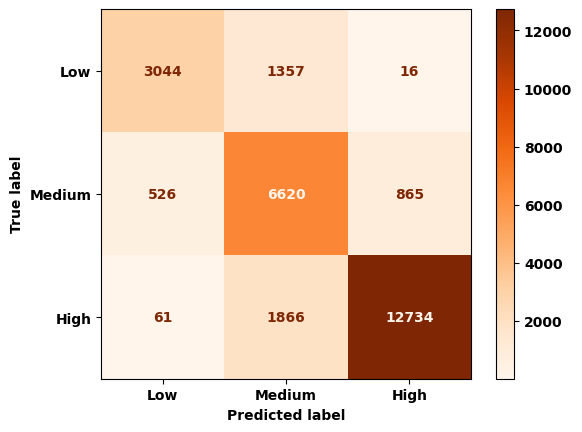

In [33]:
true, pred = import_data("solo_all_network_classifier")
print(true)
print(pred)
pred = np.argmax(pred, axis=-1)
print(pred)
conf_matrix = confusion_matrix(true, pred)
display_conf = ConfusionMatrixDisplay(conf_matrix, display_labels=["Low", "Medium", "High"])
display_conf.plot(cmap="Oranges")
plt.show()

In [14]:
carry_out_analysis(prefix="presentation")

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/knola/Desktop/FYP-Multistage-Throughput-Predictor/Datasets/Final_Outputs/presentation_multiOne_low_true_y.npy'